In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)

# Import Data

In [3]:
train = pd.read_csv('data/digitized_trainset1.csv', header=0)

In [4]:
train.columns

Index(['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       ...
       'ps_ind_04_cat_1', 'ps_ind_05_cat_NaN', 'ps_ind_05_cat_0',
       'ps_ind_05_cat_1', 'ps_ind_05_cat_2', 'ps_ind_05_cat_3',
       'ps_ind_05_cat_4', 'ps_ind_05_cat_5', 'ps_ind_05_cat_6', 'target'],
      dtype='object', length=228)

In [5]:
# Get different kinds of features
all_fs = train.columns[:-1]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

print("# total of features: %8d" % len(all_fs))
print("# of binary features: %7d" % len(binary_fs))
print("# of categorical features: %1d" % len(categorical_fs))
print("# of other features: %8d" % len(other_fs))

# total of features:      227
# of binary features:      17
# of categorical features: 184
# of other features:       26


In [6]:
binaries = train[binary_fs]

# Calculate Frequency of Class1

In [7]:
target = train['target']
total = len(target)
num_class1 = np.sum(target)
class1_frequency = num_class1/total
print('Frequency of Class1=%f' % class1_frequency)

Frequency of Class1=0.036448


# Write a function to analyze join probability of two binary features
Things to calculate/plot
- Calculate P(Class1|value=0) and P(Class1|value=1) for each feature (total 4 cond. probas)
- Calculate co-occurence of feature values (i.e get contingency table)
- Calculate chi statistic/p-value
- For each combination of values (there are 4 combos), calculate P(Class|combo)
- Assess if max(joint probas) is bigger than max(individual cond. probas)

In [8]:
class BinaryComparison:
    def __init__(self, feature1, feature2, target):
        self.features = pd.concat([feature1, feature2], axis=1)
        self.target = target
        self._table = sm.stats.Table.from_data(self.features)
        self.contingency_table_ = self._table.table_orig
        self.chi_result_ = self._table.test_nominal_association()
        self.chi_pvalue_ = self.chi_result_.pvalue
        
        self._f1 = self.features.iloc[:, 0]
        self._f2 = self.features.iloc[:, 1]
    
    
    def test_independence(self, significance_level=0.01):
        if self.chi_pvalue_ < significance_level:
            text = 'Feature association is significant (p-value=%.3f)' % self.chi_pvalue_
        else:
            text = 'Feature association is NOT significant (p-value=%.3f)' % self.chi_pvalue_
        print(text)
        return
    
    
    def calculate_individual_probas(self):
        fs = [self._f1, self._f2]
        fs_labels = ['feature1_proba', 'feature2_proba']
        individual_probas = {}
        for i, f in enumerate(fs):
            num_val0 = len(f[f == 0])
            num_val1 = len(f[f == 1])
            
            num_class1_given_val0 = len(f[(f == 0) & (self.target == 1)])
            num_class1_given_val1 = len(f[(f == 1) & (self.target == 1)])
            try:
                proba_class1_given_val0 = num_class1_given_val0 / num_val0
            except ZeroDivisionError:
                proba_class1_given_val0 = 0
                
            try:
                proba_class1_given_val1 = num_class1_given_val1 / num_val1
            except ZeroDivisionError:
                proba_class1_given_val1 = 0
                
            individual_probas[fs_labels[i]] = (proba_class1_given_val0, proba_class1_given_val1)
            
        return individual_probas
    
    
    def calculate_join_probas(self):
        data = pd.concat([self.features, self.target], axis=1)
        f10_f20 = len(data[(data.iloc[:, 0] == 0) & (data.iloc[:, 1] == 0)])
        f11_f20 = len(data[(data.iloc[:, 0] == 1) & (data.iloc[:, 1] == 0)])
        f10_f21 = len(data[(data.iloc[:, 0] == 0) & (data.iloc[:, 1] == 1)])
        f11_f21 = len(data[(data.iloc[:, 0] == 1) & (data.iloc[:, 1] == 1)])
        class1_given_f10_f20 = len(data[(data.iloc[:, 0] == 0) & (data.iloc[:, 1] == 0) & (data.iloc[:, 2] == 1)])
        class1_given_f11_f20 = len(data[(data.iloc[:, 0] == 1) & (data.iloc[:, 1] == 0) & (data.iloc[:, 2] == 1)])
        class1_given_f01_f21 = len(data[(data.iloc[:, 0] == 0) & (data.iloc[:, 1] == 1) & (data.iloc[:, 2] == 1)])
        class1_given_f11_f21 = len(data[(data.iloc[:, 0] == 1) & (data.iloc[:, 1] == 1) & (data.iloc[:, 2] == 1)])
        
        try:
            proba_00 = class1_given_f10_f20 / f10_f20
        except ZeroDivisionError:
            proba_00 = 0
            
        try:
            proba_10 = class1_given_f11_f20 / f11_f20
        except ZeroDivisionError:
            proba_10 = 0
            
        try:
            proba_01 = class1_given_f01_f21 / f10_f21
        except ZeroDivisionError:
            proba_01 = 0
            
        try:
            proba_11 = class1_given_f11_f21 / f11_f21
        except ZeroDivisionError:
            proba_11 = 0
        
        join_proba_table = pd.DataFrame({self._f1.name: [0, 1, 0, 1], 
                                         self._f2.name: [0, 0, 1, 1],
                                         'join_proba': [proba_00, proba_10, proba_01, proba_11]})
        
        return join_proba_table
    
    
    def assess_joint_result(self, mode='ratio'):
        individual_probas = self.calculate_individual_probas()
        ind_probas = [i 
                      for k, v in individual_probas.items()
                      for i in v
                     ]
        joint_probas = self.calculate_join_probas()
        
        best_ind_probas = np.max(ind_probas)
        best_joint_probas = joint_probas['join_proba'].max()
        
        if mode == 'ratio':
            gain = best_joint_probas / best_ind_probas
        elif mode == 'subtraction':
            gain = best_joint_probas - best_ind_probas
        else:
            print('Error: mode has to be ratio or subtraction')
            
        return gain

### Test the function

In [9]:
# Test case
f1 = binaries.iloc[:, 0]
f2 = binaries.iloc[:, 1]
target = train['target']

In [10]:
bc = BinaryComparison(f1, f2, target)

In [11]:
bc.test_independence()

Feature association is NOT significant (p-value=0.767)


In [12]:
bc.calculate_individual_probas()

{'feature1_proba': (0.03648184522783923, 0.03620145464525868),
 'feature2_proba': (0.036295674314038844, 0.03653752495330454)}

In [13]:
bc.calculate_join_probas()

,join_proba,ps_calc_15_bin,ps_calc_16_bin
0,0.036280,0,0
1,0.036407,1,0
2,0.036601,0,1
3,0.036080,1,1


In [14]:
bc.assess_joint_result()

1.0017480641467611

# Pairwise Analysis of All Binary Features

In [15]:
%%time
target = train['target']
num_binary_fs = len(binary_fs)
gain_table = np.zeros((num_binary_fs, num_binary_fs))

for i in range(num_binary_fs-1):
    for j in range(i+1, num_binary_fs):
        feature1 = binaries.iloc[:, i]
        feature2 = binaries.iloc[:, j]
        bc = BinaryComparison(feature1, feature2, target)
        gain = bc.assess_joint_result()
        gain_table[i, j] = gain - 1
        gain_table[j, i] = gain - 1
        
gain_table = pd.DataFrame(gain_table, columns=binary_fs, index=binary_fs)

CPU times: user 11.1 s, sys: 34.4 ms, total: 11.1 s
Wall time: 11.2 s


Heatmap for the independence/association test among binary features.
Higher gain indicates higher discriminatory power by joint.


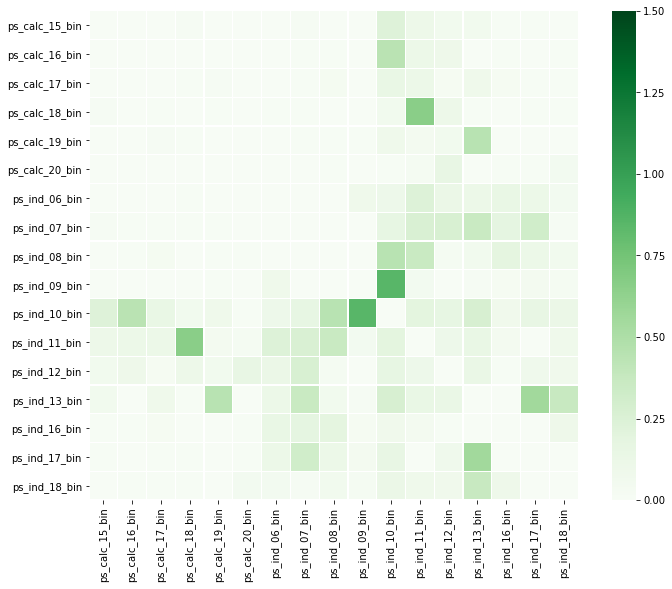

In [16]:
plt.figure(figsize=(12,9))
sns.heatmap(gain_table, linewidths=0.2, vmax=1.5, square=True, 
            cmap=cm.Greens, linecolor='white', annot=False)
print('Heatmap for the independence/association test among binary features.')
print('Higher gain indicates higher discriminatory power by joint.')

Check the following pairs manually<br>
(ind10, calc16), (ind08, ind10), (ind09, ind10), (ind11, calc18),<br>
(ind08, ind11), (ind13, calc19), (ind13, ind17), (ind13, ind18), <br>
(ind07, ind17), (ind07, ind12)

In [17]:
bc_calc16_ind10 = BinaryComparison(binaries['ps_calc_16_bin'], binaries['ps_ind_10_bin'], target)
bc_calc16_ind10.calculate_join_probas()

,join_proba,ps_calc_16_bin,ps_ind_10_bin
0,0.036281,0,0
1,0.036536,1,0
2,0.077922,0,1
3,0.041379,1,1


Binary: (0, 1) vs else

In [18]:
bc_ind08_ind10 = BinaryComparison(binaries['ps_ind_08_bin'], binaries['ps_ind_10_bin'], target)
bc_ind08_ind10.calculate_join_probas()

,join_proba,ps_ind_08_bin,ps_ind_10_bin
0,0.035354,0,0
1,0.041988,1,0
2,0.044304,0,1
3,0.078125,1,1


Binary: (1, 1) vs else

In [19]:
bc_ind09_ind10 = BinaryComparison(binaries['ps_ind_09_bin'], binaries['ps_ind_10_bin'], target)
bc_ind09_ind10.calculate_join_probas()

,join_proba,ps_ind_09_bin,ps_ind_10_bin
0,0.037177,0,0
1,0.033205,1,0
2,0.051887,0,1
3,0.100000,1,1


Categorical: (1, 1) vs (0, 1) vs else

In [20]:
bc_calc18_ind11 = BinaryComparison(binaries['ps_calc_18_bin'], binaries['ps_ind_11_bin'], target)
bc_calc18_ind11.calculate_join_probas()

,join_proba,ps_calc_18_bin,ps_ind_11_bin
0,0.036385,0,0
1,0.036547,1,0
2,0.034247,0,1
3,0.075812,1,1


Binary: (1, 1) vs else

In [21]:
bc_ind08_ind11 = BinaryComparison(binaries['ps_ind_08_bin'], binaries['ps_ind_11_bin'], target)
bc_ind08_ind11.calculate_join_probas()

,join_proba,ps_ind_08_bin,ps_ind_11_bin
0,0.035350,0,0
1,0.041958,1,0
2,0.039947,0,1
3,0.062500,1,1


Binary: (1, 1) vs else

In [22]:
bc_calc19_ind13 = BinaryComparison(binaries['ps_calc_19_bin'], binaries['ps_ind_13_bin'], target)
bc_calc19_ind13.calculate_join_probas()

,join_proba,ps_calc_19_bin,ps_ind_13_bin
0,0.036686,0,0
1,0.035961,1,0
2,0.037249,0,1
3,0.074419,1,1


Binary: (1, 1) vs else

In [23]:
bc_ind13_ind17 = BinaryComparison(binaries['ps_ind_13_bin'], binaries['ps_ind_17_bin'], target)
bc_ind13_ind17.calculate_join_probas()

,join_proba,ps_ind_13_bin,ps_ind_17_bin
0,0.033861,0,0
1,0.044586,1,0
2,0.055116,0,1
3,0.086022,1,1


Categorical: (1, 1) vs (0, 1) vs else (or use 4 categories)

In [24]:
bc_ind13_ind18 = BinaryComparison(binaries['ps_ind_13_bin'], binaries['ps_ind_18_bin'], target)
bc_ind13_ind18.calculate_join_probas()

,join_proba,ps_ind_13_bin,ps_ind_18_bin
0,0.036074,0,0
1,0.070423,1,0
2,0.038422,0,1
3,0.045024,1,1


Binary: (1, 0) vs else

In [25]:
bc_ind07_ind12 = BinaryComparison(binaries['ps_ind_07_bin'], binaries['ps_ind_12_bin'], target)
bc_ind07_ind12.calculate_join_probas()

,join_proba,ps_ind_07_bin,ps_ind_12_bin
0,0.032613,0,0
1,0.047064,1,0
2,0.041193,0,1
3,0.065539,1,1


Binary or categorical: (1, 1) vs else OR (1, 1) vs (1, 0) vs else

In [26]:
bc_ind07_ind17 = BinaryComparison(binaries['ps_ind_07_bin'], binaries['ps_ind_17_bin'], target)
bc_ind07_ind17.calculate_join_probas()

,join_proba,ps_ind_07_bin,ps_ind_17_bin
0,0.030606,0,0
1,0.043473,1,0
2,0.048279,0,1
3,0.072707,1,1


Binary or categorical: (1, 1) vs else OR (1, 1) vs (0, 1) vs else

In [27]:
bc_calc15_ind10 = BinaryComparison(binaries['ps_calc_15_bin'], binaries['ps_ind_10_bin'], target)
bc_calc15_ind10.calculate_join_probas()

,join_proba,ps_calc_15_bin,ps_ind_10_bin
0,0.036475,0,0
1,0.036195,1,0
2,0.053140,0,1
3,0.066667,1,1


Categorical or binary: (1, 1) vs (0,1) vs else OR (1, 1)&(0, 1) vs else

In [28]:
bc_calc19_ind13 = BinaryComparison(binaries['ps_calc_19_bin'], binaries['ps_ind_13_bin'], target)
bc_calc19_ind13.calculate_join_probas()

,join_proba,ps_calc_19_bin,ps_ind_13_bin
0,0.036686,0,0
1,0.035961,1,0
2,0.037249,0,1
3,0.074419,1,1


Binary: (1, 1) vs else

# Fusing Features Based on Joint Probabilities

In [29]:
binary_fs

['ps_calc_15_bin',
 'ps_calc_16_bin',
 'ps_calc_17_bin',
 'ps_calc_18_bin',
 'ps_calc_19_bin',
 'ps_calc_20_bin',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin']

fuse_pairs = [('ps_ind_09_bin', 'ps_ind_10_bin'), 
              ('ps_ind_11_bin', 'ps_calc_18_bin'), 
              ('ps_ind_13_bin', 'ps_ind_17_bin'), 
              ('ps_ind_07_bin', 'ps_ind_12_bin'),
              ('ps_ind_08_bin', 'ps_ind_16_bin')]

### ind09-ind10

In [30]:
bc_ind09_ind10 = BinaryComparison(binaries['ps_ind_09_bin'], binaries['ps_ind_10_bin'], target)
bc_ind09_ind10.calculate_join_probas()

,join_proba,ps_ind_09_bin,ps_ind_10_bin
0,0.037177,0,0
1,0.033205,1,0
2,0.051887,0,1
3,0.100000,1,1


In [31]:
vec1 = bc_ind09_ind10.features
vec1['ind09_ind10_fusion'] = 0
vec1['ind09_ind10_fusion'][(vec1['ps_ind_09_bin'] == 0) & (vec1['ps_ind_10_bin'] == 1)] = 1
vec1['ind09_ind10_fusion'][(vec1['ps_ind_09_bin'] == 1) & (vec1['ps_ind_10_bin'] == 1)] = 2
ind09_ind10_fusion = vec1['ind09_ind10_fusion']

### ind11-calc18

In [32]:
bc_ind11_calc18 = BinaryComparison(binaries['ps_ind_11_bin'], binaries['ps_calc_18_bin'], target)
bc_ind11_calc18.calculate_join_probas()

,join_proba,ps_calc_18_bin,ps_ind_11_bin
0,0.036385,0,0
1,0.034247,0,1
2,0.036547,1,0
3,0.075812,1,1


In [33]:
vec2 = bc_ind11_calc18.features
vec2['ind11_calc18_fusion'] = 0
vec2['ind11_calc18_fusion'][(vec2['ps_ind_11_bin'] == 1) & (vec2['ps_calc_18_bin'] == 1)] = 1
ind11_calc18_fusion = vec2['ind11_calc18_fusion']

### ind13-ind17

In [34]:
bc_ind13_ind17 = BinaryComparison(binaries['ps_ind_13_bin'], binaries['ps_ind_17_bin'], target)
bc_ind13_ind17.calculate_join_probas()

,join_proba,ps_ind_13_bin,ps_ind_17_bin
0,0.033861,0,0
1,0.044586,1,0
2,0.055116,0,1
3,0.086022,1,1


In [35]:
vec3 = bc_ind13_ind17.features
vec3['ind13_ind17_fusion'] = 0
vec3['ind13_ind17_fusion'][(vec3['ps_ind_13_bin'] == 0) & (vec3['ps_ind_17_bin'] == 1)] = 1
vec3['ind13_ind17_fusion'][(vec3['ps_ind_13_bin'] == 1) & (vec3['ps_ind_17_bin'] == 1)] = 2
ind13_ind17_fusion = vec3['ind13_ind17_fusion']

### ind07-ind12

In [36]:
bc_ind07_ind12 = BinaryComparison(binaries['ps_ind_07_bin'], binaries['ps_ind_12_bin'], target)
bc_ind07_ind12.calculate_join_probas()

,join_proba,ps_ind_07_bin,ps_ind_12_bin
0,0.032613,0,0
1,0.047064,1,0
2,0.041193,0,1
3,0.065539,1,1


In [37]:
vec4 = bc_ind07_ind12.features
vec4['ind07_ind12_fusion'] = 0
vec4['ind07_ind12_fusion'][(vec4['ps_ind_07_bin'] == 1) & (vec4['ps_ind_12_bin'] == 0)] = 1
vec4['ind07_ind12_fusion'][(vec4['ps_ind_07_bin'] == 1) & (vec4['ps_ind_12_bin'] == 1)] = 2
ind07_ind12_fusion = vec4['ind07_ind12_fusion']

### ind08-ind16

In [38]:
bc_ind08_ind16 = BinaryComparison(binaries['ps_ind_08_bin'], binaries['ps_ind_16_bin'], target)
bc_ind08_ind16.calculate_join_probas()

,join_proba,ps_ind_08_bin,ps_ind_16_bin
0,0.042113,0,0
1,0.052060,1,0
2,0.031870,0,1
3,0.036997,1,1


In [39]:
vec5 = bc_ind08_ind16.features
vec5['ind08_ind16_fusion'] = 0
vec5['ind08_ind16_fusion'][(vec5['ps_ind_08_bin'] == 1) & (vec5['ps_ind_16_bin'] == 0)] = 1
ind08_ind16_fusion = vec5['ind08_ind16_fusion']

<b>Fuse the features</b>

In [40]:
fuse1 = ['ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_calc_18_bin', 
         'ps_ind_13_bin', 'ps_ind_17_bin', 'ps_ind_07_bin', 'ps_ind_12_bin',
         'ps_ind_08_bin', 'ps_ind_16_bin']
nonfuse1 = [f for f in binary_fs if f not in fuse1]
nonfuse_features1 = binaries[nonfuse1]

In [41]:
fusion1_1 = encode_my_categorical_labels(ind09_ind10_fusion)
fusion1_2 = encode_my_categorical_labels(ind13_ind17_fusion)
fusion1_3 = encode_my_categorical_labels(ind07_ind12_fusion)

In [42]:
fused_binaries1 = pd.concat([nonfuse_features1, fusion1_1, fusion1_2, fusion1_3, 
                             ind11_calc18_fusion, ind08_ind16_fusion], axis=1)

In [43]:
fused_binaries1.head(5)

,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_06_bin,ps_ind_18_bin,ind09_ind10_fusion_0,ind09_ind10_fusion_1,ind09_ind10_fusion_2,ind13_ind17_fusion_0,ind13_ind17_fusion_1,ind13_ind17_fusion_2,ind07_ind12_fusion_0,ind07_ind12_fusion_1,ind07_ind12_fusion_2,ind11_calc18_fusion,ind08_ind16_fusion
0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
1,0,1,1,1,0,0,1,1,0,0,1,0,0,1,0,0,0,1
2,0,1,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0
4,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0


# Pairwise Analysis of Newly Fused Binary Features

In [44]:
%%time
target = train['target']
num_fs = len(fused_binaries1.columns)
gain_table2 = np.zeros((num_fs, num_fs))
pval_table2 = np.zeros((num_fs, num_fs))

for i in range(num_fs-1):
    for j in range(i+1, num_fs):
        feature1 = fused_binaries1.iloc[:, i]
        feature2 = fused_binaries1.iloc[:, j]
        bc = BinaryComparison(feature1, feature2, target)
        gain = bc.assess_joint_result(mode='subtraction')
        pval = bc.chi_pvalue_
        
        gain_table2[i, j] = gain
        gain_table2[j, i] = gain
        
        pval_table2[i, j] = pval
        pval_table2[j, i] = pval
        
gain_table2 = pd.DataFrame(gain_table, columns=fused_binaries1.columns, index=fused_binaries1.columns)
pval_table2 = pd.DataFrame(pval_table2, columns=fused_binaries1.columns, index=fused_binaries1.columns)

CPU times: user 11.9 s, sys: 46.9 ms, total: 12 s
Wall time: 12 s


Heatmap for the independence/association test among binary features.
Higher pvalue indicates higher independence btw features.


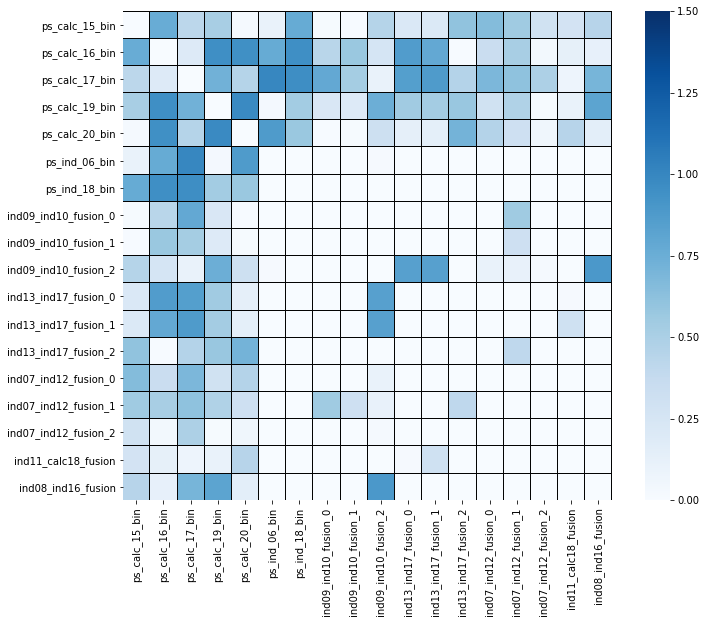

In [45]:
plt.figure(figsize=(12,9))
sns.heatmap(pval_table2, linewidths=0.05, vmax=1.5, square=True, 
            cmap=cm.Blues, linecolor='0.01', annot=False)
print('Heatmap for the independence/association test among binary features.')
print('Higher pvalue indicates higher independence btw features.')

Heatmap for the independence/association test among binary features.
Higher gain indicates higher discriminatory power by joint.


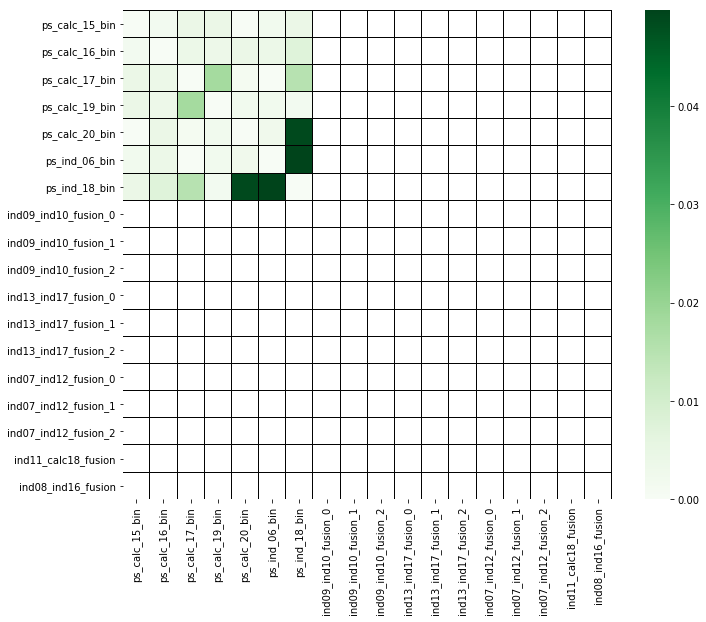

In [46]:
plt.figure(figsize=(12,9))
sns.heatmap(gain_table2, linewidths=0.05, square=True, #vmax=1.5, 
            cmap=cm.Greens, linecolor='0.01', annot=False)
print('Heatmap for the independence/association test among binary features.')
print('Higher gain indicates higher discriminatory power by joint.')

In [47]:
fused_binaries1.columns

Index(['ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin', 'ps_ind_06_bin', 'ps_ind_18_bin',
       'ind09_ind10_fusion_0', 'ind09_ind10_fusion_1', 'ind09_ind10_fusion_2',
       'ind13_ind17_fusion_0', 'ind13_ind17_fusion_1', 'ind13_ind17_fusion_2',
       'ind07_ind12_fusion_0', 'ind07_ind12_fusion_1', 'ind07_ind12_fusion_2',
       'ind11_calc18_fusion', 'ind08_ind16_fusion'],
      dtype='object')

In [68]:
bc0 = BinaryComparison(fused_binaries1.loc[:, 'ind09_ind10_fusion_0'], 
                       fused_binaries1.loc[:, 'ind13_ind17_fusion_0'], target)
bc0.calculate_join_probas()

,ind09_ind10_fusion_0,ind13_ind17_fusion_0,join_proba
0,0,0,0.063830
1,1,0,0.055150
2,0,1,0.051429
3,1,1,0.033864


In [48]:
bc1 = BinaryComparison(fused_binaries1.loc[:, 'ps_ind_06_bin'], fused_binaries1.loc[:, 'ps_ind_18_bin'], target)
bc1.calculate_join_probas()

,join_proba,ps_ind_06_bin,ps_ind_18_bin
0,0.041200,0,0
1,0.028287,1,0
2,0.043655,0,1
3,0.029974,1,1


In [65]:
bc2 = BinaryComparison(fused_binaries1.loc[:, 'ps_calc_20_bin'], fused_binaries1.loc[:, 'ps_ind_18_bin'], target)
bc2.calculate_join_probas()

,join_proba,ps_calc_20_bin,ps_ind_18_bin
0,0.036247,0,0
1,0.035182,1,0
2,0.038111,0,1
3,0.040330,1,1


In [66]:
bc3 = BinaryComparison(fused_binaries1.loc[:, 'ps_calc_17_bin'], fused_binaries1.loc[:, 'ps_calc_19_bin'], target)
bc3.calculate_join_probas()

,join_proba,ps_calc_17_bin,ps_calc_19_bin
0,0.037349,0,0
1,0.036154,1,0
2,0.034867,0,1
3,0.036913,1,1


# Assessing usefulness of feature by comparing conditional probability to Class Frequency
Try with both fuese binaries and categorical features

In [49]:
def assess_feature_frequency(feature, target, mode='subtraction'):
    total = len(feature)
    num_class1 = np.sum(target)
    proba_class1 = num_class1 / total
    
    num_val0 = len(feature[feature == 0])
    num_val1 = len(feature[feature == 1])
    num_class1_given_val0 = len(feature[(feature == 0) & (target == 1)])
    num_class1_given_val1 = len(feature[(feature == 1) & (target == 1)])
    
    if num_val0 == 0:
        proba_class1_given_val0 = 0
    else:
        proba_class1_given_val0 = num_class1_given_val0 / num_val0
    
    if num_val1 == 1:
        proba_class1_given_val1 = 0
    else:
        proba_class1_given_val1 = num_class1_given_val1 / num_val1
        
    best_cond_proba = max(proba_class1_given_val0, proba_class1_given_val1)
    if mode == 'subtraction':
        differential = best_cond_proba - proba_class1
    elif mode == 'ratio':
        differential = best_cond_proba / proba_class1
    else:
        print('Error: the mode must be subtration or ratio')
    return differential

### Binaries and Fused Binaries

In [50]:
for f in fused_binaries1.columns:
    diff = assess_feature_frequency(fused_binaries1[f], target, mode='subtraction')
    print('%s Margin: %.3f%%' % (f, 100*diff))

ps_calc_15_bin Margin: 0.003%
ps_calc_16_bin Margin: 0.009%
ps_calc_17_bin Margin: 0.004%
ps_calc_19_bin Margin: 0.024%
ps_calc_20_bin Margin: 0.009%
ps_ind_06_bin Margin: 0.514%
ps_ind_18_bin Margin: 0.201%
ind09_ind10_fusion_0 Margin: 1.761%
ind09_ind10_fusion_1 Margin: 1.544%
ind09_ind10_fusion_2 Margin: 6.355%
ind13_ind17_fusion_0 Margin: 1.871%
ind13_ind17_fusion_1 Margin: 1.867%
ind13_ind17_fusion_2 Margin: 4.957%
ind07_ind12_fusion_0 Margin: 1.090%
ind07_ind12_fusion_1 Margin: 1.062%
ind07_ind12_fusion_2 Margin: 2.909%
ind11_calc18_fusion Margin: 3.936%
ind08_ind16_fusion Margin: 1.561%


In [51]:
useful_binaries = []
for f in fused_binaries1.columns:
    diff = assess_feature_frequency(fused_binaries1[f], target, mode='ratio')
    if diff >= 1.1:
        useful_binaries.append(f)
    print('%s %% gain: %.1f%%' % (f, 100*(diff-1)))

ps_calc_15_bin % gain: 0.1%
ps_calc_16_bin % gain: 0.2%
ps_calc_17_bin % gain: 0.1%
ps_calc_19_bin % gain: 0.7%
ps_calc_20_bin % gain: 0.2%
ps_ind_06_bin % gain: 14.1%
ps_ind_18_bin % gain: 5.5%
ind09_ind10_fusion_0 % gain: 48.3%
ind09_ind10_fusion_1 % gain: 42.4%
ind09_ind10_fusion_2 % gain: 174.4%
ind13_ind17_fusion_0 % gain: 51.3%
ind13_ind17_fusion_1 % gain: 51.2%
ind13_ind17_fusion_2 % gain: 136.0%
ind07_ind12_fusion_0 % gain: 29.9%
ind07_ind12_fusion_1 % gain: 29.1%
ind07_ind12_fusion_2 % gain: 79.8%
ind11_calc18_fusion % gain: 108.0%
ind08_ind16_fusion % gain: 42.8%


In [52]:
useful_binaries

['ps_ind_06_bin',
 'ind09_ind10_fusion_0',
 'ind09_ind10_fusion_1',
 'ind09_ind10_fusion_2',
 'ind13_ind17_fusion_0',
 'ind13_ind17_fusion_1',
 'ind13_ind17_fusion_2',
 'ind07_ind12_fusion_0',
 'ind07_ind12_fusion_1',
 'ind07_ind12_fusion_2',
 'ind11_calc18_fusion',
 'ind08_ind16_fusion']

### Categoricals

In [53]:
categoricals = train[categorical_fs]

In [54]:
diffs = []
useless = []
fs_cutoff5 = []
fs_cutoff10 = []
fs_cutoff20 = []

for f in categoricals.columns:
    diff = assess_feature_frequency(categoricals[f], target, mode='ratio')
    diffs.append(diff-1)
    if diff >= 1.2:
        fs_cutoff20.append(f)
    if diff >= 1.1:
        fs_cutoff10.append(f)
    if diff >= 1.05:
        fs_cutoff5.append(f)
    if diff < 1.05:
        useless.append(f)
    print('%s %% gain: %.1f%%' % (f, 100*(diff-1)))

ps_car_01_cat_0 % gain: 20.4%
ps_car_01_cat_1 % gain: 28.5%
ps_car_01_cat_10 % gain: 1.4%
ps_car_01_cat_11 % gain: 14.1%
ps_car_01_cat_2 % gain: 17.7%
ps_car_01_cat_3 % gain: 3.0%
ps_car_01_cat_4 % gain: 7.4%
ps_car_01_cat_5 % gain: 7.7%
ps_car_01_cat_6 % gain: 2.1%
ps_car_01_cat_7 % gain: 9.1%
ps_car_01_cat_8 % gain: 19.1%
ps_car_01_cat_9 % gain: 49.3%
ps_car_01_cat_NaN % gain: 771.8%
ps_car_02_cat_0 % gain: 35.8%
ps_car_02_cat_1 % gain: 35.8%
ps_car_02_cat_NaN % gain: 0.0%
ps_car_03_cat_0 % gain: 8.5%
ps_car_03_cat_1 % gain: 32.5%
ps_car_03_cat_NaN % gain: 22.9%
ps_car_04_cat_0 % gain: 41.4%
ps_car_04_cat_1 % gain: 34.0%
ps_car_04_cat_2 % gain: 29.5%
ps_car_04_cat_3 % gain: 41.5%
ps_car_04_cat_4 % gain: 0.0%
ps_car_04_cat_5 % gain: 96.3%
ps_car_04_cat_6 % gain: 61.8%
ps_car_04_cat_7 % gain: 156.6%
ps_car_04_cat_8 % gain: 37.6%
ps_car_04_cat_9 % gain: 69.8%
ps_car_05_cat_0 % gain: 10.1%
ps_car_05_cat_1 % gain: 11.0%
ps_car_05_cat_NaN % gain: 10.5%
ps_car_06_cat_0 % gain: 1.9%
ps_car_0

In [55]:
print('Total: %d' % (len(categorical_fs)))
print('>=20%%: %d' % (len(fs_cutoff20)))
print('>=10%%: %d' % (len(fs_cutoff10)))
print('>= 5%%: %d' % (len(fs_cutoff5)))
print(' < 5%%: %d' % (len(useless)))

Total: 184
>=20%: 72
>=10%: 90
>= 5%: 109
 < 5%: 75


In [56]:
pd.Series(diffs).describe()

count    184.000000
mean       0.340833
std        0.989343
min        0.000008
25%        0.003214
50%        0.090237
75%        0.394448
max        9.908572
dtype: float64

# Make a new binary-categorical feature space and save

In [57]:
binaries_v2 = fused_binaries1[useful_binaries]
categoricals_v2 = categoricals[fs_cutoff5]
bincats_v2 = pd.concat([binaries_v2, categoricals_v2], axis=1)

In [58]:
bincats_v2.head(5)

,ps_ind_06_bin,ind09_ind10_fusion_0,ind09_ind10_fusion_1,ind09_ind10_fusion_2,ind13_ind17_fusion_0,ind13_ind17_fusion_1,ind13_ind17_fusion_2,ind07_ind12_fusion_0,ind07_ind12_fusion_1,ind07_ind12_fusion_2,...,ps_ind_04_cat_1,ps_ind_04_cat_NaN,ps_ind_05_cat_0,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_ind_05_cat_NaN
0,0,1,0,0,0,1,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
3,1,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,1,0,0,1,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0


In [59]:
bincats_v2.to_csv('./data/bincats_v2.csv', index=False)

# Quick try on new bincat_v2

In [60]:
if True:
    from imblearn.under_sampling import TomekLinks, RandomUnderSampler
    from imblearn.over_sampling import SMOTE, ADASYN
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.svm import LinearSVC
    from sklearn.metrics import make_scorer
    from sklearn.metrics import roc_auc_score

In [61]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [62]:
bincat_v1 = pd.concat([binaries, categoricals], axis=1)

In [63]:
datasets = [bincat_v1, bincats_v2]
datasets_labels = ['No Selection', 'Selected']

No Selection: Gini=0.216+/-0.000, Best=0.216
Selected: Gini=0.174+/-0.000, Best=0.174
CPU times: user 4min 58s, sys: 2.08 s, total: 5min
Wall time: 1min 1s


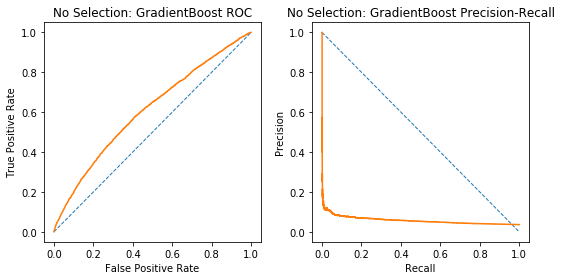

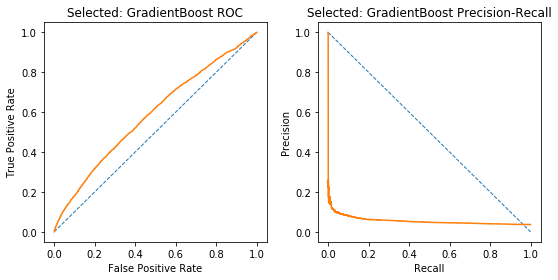

In [64]:
%%time
for j, data in enumerate(datasets):
    label = datasets_labels[j]
    
    fig = plt.figure(figsize=(8, 4))
    ax21 = fig.add_subplot(1, 2, 1)
    ax22 = fig.add_subplot(1, 2, 2)

    neutral_line = np.linspace(0, 1, 10)
    ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

    ginis_xgb = []

    X_new = np.array(data)
    y = np.array(target)

    for i in range(1):

        rstate = None
        X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=rstate)

        num_class1 = np.sum(y_train)
        num_class1_to_resample = 2 * num_class1
        num_class0_to_resample = int(1 * num_class1_to_resample)

        # First, randomly undersample the majority
        rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
        X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

        # Then use SMOTE to oversample the minority
        smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
        X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

        # GradientBoost
        clf = XGBClassifier(gamma=1, max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
        clf.fit(X_res, y_res)

        y_pred2 = clf.predict(X_test)
        y_proba2 = clf.predict_proba(X_test)
        ginis_xgb.append(my_gini(y_test, y_proba2))
        report2 = classification_report(y_test, y_pred2, digits=4,
                                       labels=None, target_names=None)

        precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
        fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
        ax21.plot(fpr2, tpr2)
        ax21.set_xlabel('False Positive Rate')
        ax21.set_ylabel('True Positive Rate')
        ax21.set_title('%s: GradientBoost ROC' % label)
        ax22.plot(recall2, precision2)
        ax22.set_xlabel('Recall')
        ax22.set_ylabel('Precision')
        ax22.set_title('%s: GradientBoost Precision-Recall' % label)

    plt.tight_layout()

    print('%s: Gini=%.3f+/-%.3f, Best=%.3f' % (label, np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

## Concluding comment
Though xgboost didn't perform as hoped right away, fusion of features to reduce complexity and boost conditional probability looks promising. The issues now are: 1) how to feal with features whose conditional probas of class1 are lower or marginally better than the bulk class1 frequency, and 2) loss of information by encoding into categoricals. 2) can be resolved by CategoricalComparison class to assess any gain in joint probability of two categorical features. This is to be implemented and explored next.